This notebook compares the ts_wep donut masks to the images from phosim and batoid

In [1]:
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import galsim
import batoid
import wfsim
from scipy.ndimage import rotate

import os
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.WfEstimator import WfEstimator
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.Utility import CamType, DefocalType, getConfigDir

import pickle
from scipy.ndimage import binary_dilation

/astro/store/epyc/projects/lsst_comm/lsstinstall/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
closedloop_dir = "/phys/users/jfc20/lsst/exp_closedLoop_output3"

In [3]:
# load the butler
butler_repo = closedloop_dir + "/phosimData"
butler = Butler(butler_repo)
registry = butler.registry

# determine the collection to pull from
iteration = 0
collection = f"ts_phosim_{9006000 + iteration*10}"

# select one of the chips
chipIdx = 1

# get the phosim data references from the butler
intraRef = list(registry.queryDatasets(collections=collection, datasetType="donutStampsIntra"))[chipIdx]
extraRef = list(registry.queryDatasets(collections=collection, datasetType="donutStampsExtra"))[chipIdx]

# load the opd
opd = np.genfromtxt(closedloop_dir + f"/iter{iteration}/img/opd.zer")[chipIdx]

In [4]:
# first all the phosim stuff
intraStamp = butler.getDirect(intraRef)[0]
img = intraStamp.stamp_im.getImage().getArray()
detector = intraStamp.getCamera().get(intraStamp.detector_name)
pIntraImg = rotate(img, -detector.getOrientation().getYaw().asDegrees()).T

extraStamp = butler.getDirect(extraRef)[0]
img = extraStamp.stamp_im.getImage().getArray()
detector = extraStamp.getCamera().get(extraStamp.detector_name)
pExtraImg = rotate(img, -detector.getOrientation().getYaw().asDegrees()).T

pWfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
pWfEst.config(sizeInPix=160, units="um", algo="exp", debugLevel=1)

pWfEst.setImg(
    intraStamp.calcFieldXY(),
    DefocalType.Intra,
    image=pIntraImg.copy(),
)

pWfEst.setImg(
    extraStamp.calcFieldXY(),
    DefocalType.Extra,
    image=pExtraImg.copy(),
)

pZkEst = pWfEst.calWfsErr()

In [5]:
# now the batoid stuff

def getStampMetaData(stamp):
    # get the field angle
    fieldAngle = stamp.calcFieldXY() # degrees
    fieldAngle = np.deg2rad(fieldAngle) # -> radians
    
    # and the detector
    detector = stamp.detector_name
    
    # get the stamp image object
    img = stamp.comp_im.getImgObj()

    # get the number of photons to simulate
    imgMask = img._centroidFind.getImgBinary(img.image)
    nphotons = int(img.image[imgMask.astype(bool)].sum())

    # and the standard deviation of the background
    bgMask = 1 - imgMask
    noise = np.std(img.image[bgMask.astype(bool)])
    
    # pick a temperature
    T = 7_000 # K
    
    # make a blackbody SED
    sed = wfsim.BBSED(T)
    
    return fieldAngle, detector, nphotons, noise, sed

# load the bandpass
band = intraRef.dataId["band"]
bandpass = galsim.Bandpass(f"LSST_{band}.dat", wave_type="nm")

# Setup observation parameters.  Making ~plausible stuff up.
observation = {
    'zenith': 30 * galsim.degrees,
    'raw_seeing': 0.7 * galsim.arcsec,  # zenith 500nm seeing
    'wavelength': bandpass.effective_wavelength,
    'exptime': 15.0,  # seconds
    'temperature': 293.,  # Kelvin
    'pressure': 69.,  #kPa
    'H2O_pressure': 1.0  #kPa
}

# Setup atmospheric parameters
atm_kwargs = {
    'screen_size': 819.2,
    'screen_scale': 0.1,
    'nproc': 6  # create screens in parallel using this many CPUs
}

# create a fiducial simulator
rng = np.random.default_rng(0)
lsst = batoid.Optic.fromYaml(f"LSST_{band}.yaml")
simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    lsst,
    bandpass,
    name="R00_SW0",
    rng=rng
)

# setup WfEstimator
bWfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
bWfEst.config(sizeInPix=160, units="um", algo="exp", debugLevel=1)

# create the perturbed telescope
R_outer = lsst.pupilSize / 2
R_inner = R_outer * lsst.pupilObscuration
phase = batoid.Zernike(
    np.pad(opd, pad_width=(4,0), mode='constant') * 1e-6,
    R_outer=R_outer,
    R_inner=R_inner,
)
perturbed = batoid.CompoundOptic(
        (
            batoid.optic.OPDScreen(
                batoid.Plane(),
                phase,
                name="PhaseScreen",
                obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                coordSys=lsst.stopSurface.coordSys
            ),
            *lsst.items,
        ),
        name="PerturbedLSST",
        backDist=lsst.backDist,
        pupilSize=lsst.pupilSize,
        inMedium=lsst.inMedium,
        stopSurface=lsst.stopSurface,
        sphereRadius=lsst.sphereRadius,
        pupilObscuration=lsst.pupilObscuration
)

# pull out the metadata we need for the intrafocal star
fieldAngle, detector, nphotons, noise, sed = getStampMetaData(intraStamp)

# create the intrafocal simulator
intra = perturbed.withGloballyShiftedOptic("Detector", [0, 0, -0.0015])
simulator.telescope = intra
simulator.set_name(detector)

# simulate the intrafocal star
simulator.add_star(*fieldAngle, sed, nphotons, rng)
simulator.add_background(noise, rng)

# select stamp center
x, y = np.array(simulator.wcs.radecToxy(*fieldAngle, galsim.radians))
x = int(x - simulator.image.xmin)
y = int(y - simulator.image.ymin)

# determine stamp shape
shape = pIntraImg.shape
dx, dy = shape[0] // 2, shape[1] // 2

# cutout stamp
bIntraImg = simulator.image.array[y-dy:y+dy, x-dx:x+dx]

# put the intrafocal stamp in the wavefront estimator
bWfEst.reset()
bWfEst.setImg(
    np.rad2deg(fieldAngle),
    DefocalType.Intra,
    image=bIntraImg.copy(),
)

# pull out the metadata we need for the extrafocal star
fieldAngle, detector, nphotons, noise, sed = getStampMetaData(extraStamp)

# create the extrafocal simulator
extra = perturbed.withGloballyShiftedOptic("Detector", [0, 0, +0.0015])
simulator.telescope = extra
simulator.set_name(detector)

# simulate the intrafocal star
simulator.add_star(*fieldAngle, sed, nphotons, rng)
simulator.add_background(noise, rng)

# select stamp center
x, y = np.array(simulator.wcs.radecToxy(*fieldAngle, galsim.radians))
x = int(x - simulator.image.xmin)
y = int(y - simulator.image.ymin)

# determine stamp shape
shape = pExtraImg.shape
dx, dy = shape[0] // 2, shape[1] // 2

# cutout stamp
bExtraImg = simulator.image.array[y-dy:y+dy, x-dx:x+dx]

# put the extrafocal stamp in the wavefront estimator
bWfEst.setImg(
    np.rad2deg(fieldAngle),
    DefocalType.Extra,
    image=bExtraImg.copy(),
)

bZkEst = bWfEst.calWfsErr()

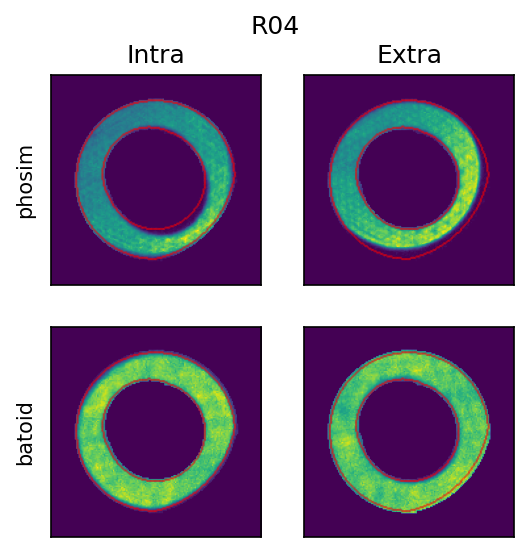

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=150)

# set all the titles
fig.suptitle(extraStamp.detector_name[:3])
axes[0, 0].set(xticks=[], yticks=[], ylabel="phosim", title="Intra")
axes[0, 1].set(xticks=[], yticks=[], title="Extra")
axes[1, 0].set(xticks=[], yticks=[], ylabel="batoid")
axes[1, 1].set(xticks=[], yticks=[])

# plot the phosim images
hist = pWfEst.algo.getHistory()[0]
axes[0, 0].imshow(hist["compI1"], origin="lower")
axes[0, 1].imshow(hist["compI2"], origin="lower")

# and the phosim mask
# note because of the way I am computing and drawing the boundary, 
# we must transpose the mask to get the correct orientation
mask = hist["pupilMask"].T
kernel = np.zeros((3,3),dtype=int); kernel[1] = 1; kernel[:,1] = 1
boundary = binary_dilation(mask == 0, kernel) & mask
axes[0, 0].scatter(*np.where(boundary > 0), marker=".", c="r", s=5, edgecolors="none", alpha=0.45)
axes[0, 1].scatter(*np.where(boundary > 0), marker=".", c="r", s=5, edgecolors="none", alpha=0.45)

# plot the batoid images
hist = bWfEst.algo.getHistory()[0]
axes[1, 0].imshow(hist["compI1"], origin="lower")
axes[1, 1].imshow(hist["compI2"], origin="lower")

# and the batoid mask
# note because of the way I am computing and drawing the boundary, 
# we must transpose the mask to get the correct orientation
mask = hist["pupilMask"].T
kernel = np.zeros((3,3),dtype=int); kernel[1] = 1; kernel[:,1] = 1 
boundary = binary_dilation(mask == 0, kernel) & mask
axes[1, 0].scatter(*np.where(boundary > 0), marker=".", c="r", s=5, edgecolors="none", alpha=0.45)
axes[1, 1].scatter(*np.where(boundary > 0), marker=".", c="r", s=5, edgecolors="none", alpha=0.45)

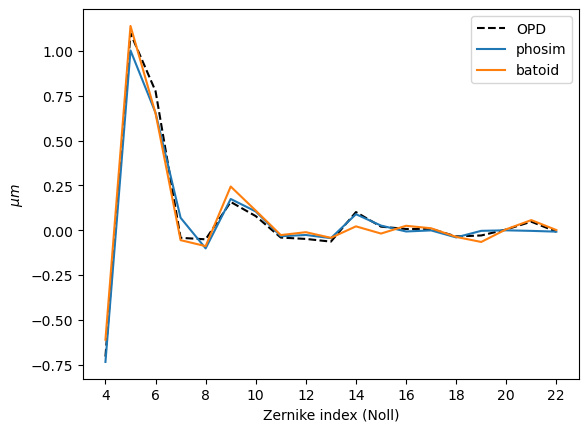

In [7]:
fig, ax = plt.subplots()

zk_grid = np.arange(4, 23)
ax.plot(zk_grid, opd, c="k", ls="--", label="OPD")
ax.plot(zk_grid, pZkEst, label="phosim")
ax.plot(zk_grid, -bZkEst, label="batoid")
ax.legend()

ax.set(xticks=np.arange(4, 23, 2), xlabel="Zernike index (Noll)", ylabel="$\mu m$")
plt.show()